In [35]:
from src.dpsk_modem import *
from src.ofdm_modem import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [36]:
# settings
np.random.seed(0)
fs_hz = 2700
scs_hz = 15
num_sc = 32
num_ofdm_symbols = 6
bits_per_sample = 2 # [dbpsk: 1, dqpsk: 2, d8psk: 3]
num_transmit_bits = num_sc * (num_ofdm_symbols-1) * bits_per_sample

# modem block init
dpsk_block = DPSKModem(bits_per_sample=bits_per_sample)
ofdm_block = OFDMModem(num_sc=num_sc)


In [37]:
def est_papr_db(signal: np.ndarray) -> float:
    papr = np.max(np.abs(signal)**2) / np.mean(np.abs(signal)**2)
    return 10*np.log10(papr)

def est_ber(tx_bits: np.ndarray, rx_bits: np.ndarray) -> float:
    return np.sum(np.abs(tx_bits-rx_bits)) / tx_bits.shape[0]

In [38]:
# processing
tx_bits = np.random.randint(low=0, high=2, size=num_transmit_bits)
tx_signal = ofdm_block.process_tx(tx_bits, dpsk_block, num_ofdm_symbols)
rx_bits = ofdm_block.process_rx(tx_signal, dpsk_block, num_ofdm_symbols)
print('CP len: ', ofdm_block.cp_len)
print('Tx bits: ', *tx_bits[:min(10, len(tx_bits))])
print('Rx bits: ', *rx_bits[:min(10, len(tx_bits))])
print("Correct: ", np.array_equal(rx_bits, tx_bits))
print("Tx signal PAPR [dB]: ", np.round(est_papr_db(tx_signal), 1))

CP len:  6
Tx bits:  0 1 1 0 1 1 1 1 1 1
Rx bits:  0 1 1 0 1 1 1 1 1 1
Correct:  True
Tx signal PAPR [dB]:  12.1


In [39]:
# with noise
snr_db = 14
noise_var = 10 ** (- snr_db/ 10)
tx_bits = np.random.randint(low=0, high=2, size=num_transmit_bits)
tx_signal = ofdm_block.process_tx(tx_bits, dpsk_block, num_ofdm_symbols)
rx_signal = tx_signal + np.sqrt(noise_var / 2) * (np.random.randn(tx_signal.shape[0]) + 1j * np.random.randn(tx_signal.shape[0]))
rx_bits = ofdm_block.process_rx(rx_signal, dpsk_block, num_ofdm_symbols)
print('Tx bits: ', *tx_bits[:min(10, len(tx_bits))])
print('Rx bits: ', *rx_bits[:min(10, len(tx_bits))])
print("Correct: ", np.array_equal(rx_bits, tx_bits))
print('BER: ', est_ber(tx_bits, rx_bits))
print("Tx signal PAPR [dB]: ", np.round(est_papr_db(tx_signal), 1))
print("Rx signal PAPR [dB]: ", np.round(est_papr_db(rx_signal), 1))

Tx bits:  1 1 1 0 0 0 0 1 1 1
Rx bits:  1 1 1 0 0 0 0 1 1 1
Correct:  True
BER:  0.0
Tx signal PAPR [dB]:  12.0
Rx signal PAPR [dB]:  11.9


In [40]:
# with multipath propagation
channel_h = np.array([1, 0, 0, 0, 0.9, 0.5])
tx_bits = np.random.randint(low=0, high=2, size=num_transmit_bits)
tx_signal = ofdm_block.process_tx(tx_bits, dpsk_block, num_ofdm_symbols, fs_hz=fs_hz, scs_hz=scs_hz)
rx_signal = np.convolve(tx_signal, channel_h, 'full')
rx_bits = ofdm_block.process_rx(rx_signal[:tx_signal.shape[0]], dpsk_block, num_ofdm_symbols, fs_hz=fs_hz, scs_hz=scs_hz)
print('Tx bits: ', *tx_bits[:min(10, len(tx_bits))])
print('Rx bits: ', *rx_bits[:min(10, len(tx_bits))])
print("Correct: ", np.array_equal(rx_bits, tx_bits))
print('BER: ', est_ber(tx_bits, rx_bits))
print("Tx signal PAPR [dB]: ", np.round(est_papr_db(tx_signal), 1))
print("Rx signal PAPR [dB]: ", np.round(est_papr_db(rx_signal), 1))

Tx bits:  0 0 1 1 0 0 0 0 1 0
Rx bits:  0 0 1 1 0 0 0 0 1 0
Correct:  True
BER:  0.0
Tx signal PAPR [dB]:  12.1
Rx signal PAPR [dB]:  11.8


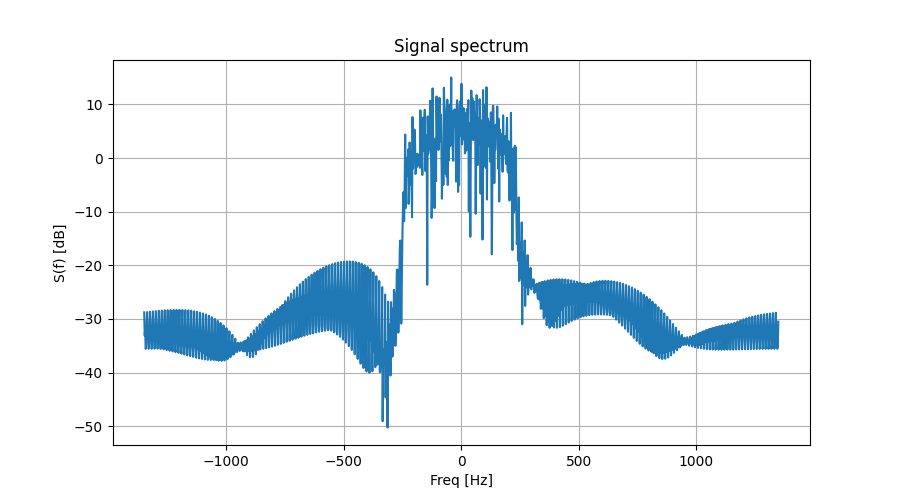

In [41]:
fig1 = plt.figure(figsize=(9,5))
ax1 = fig1.add_subplot(111)

rx_signal_trim = rx_signal[:tx_signal.shape[0]]
ax1.set_title(r'Signal spectrum')
ax1.plot(np.linspace(-fs_hz/2, fs_hz/2, len(rx_signal_trim)), 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(rx_signal_trim, norm="ortho")))))
ax1.set_xlabel('Freq [Hz]')
ax1.set_ylabel('S(f) [dB]')
ax1.grid()
plt.show()